# Basic Lane Finding

The goal of this project was to understand and evaluate an introductory computer vision method for finding lane lines in an image. 

Finding lanes is at the core of several driver assist and self driving technologies such as [Lane Departure Warning](https://en.wikipedia.org/wiki/Lane_departure_warning_system) and lane keeping.  

Below is a flowchart explaining the lane detection algorithim from the Wikipedia article on Lane Departure Warning Systems. It percisly describes an advanced method for detecting lanes which performe camera calibriation and perspective transform prior to [Canny](https://en.wikipedia.org/wiki/Canny_edge_detector) and [Hough](https://en.wikipedia.org/wiki/Hough_transform). The expample below does not utalize these steps, however, we will make use of them in future examples.

![Lane Detection Flowchart](https://upload.wikimedia.org/wikipedia/en/d/d9/Lane_Detection_Algorithm.jpg "Lane Detection Algorithm from Wikipedia")

The pipeline below consists of the following steps. 

1. Convert to Grayscale - Simplifies the image for next step of the pipeline
2. Blur - Reduces the amount of information in the image so only significant details remain
3. Canny Edge Detection - Find edges where gradient change between pixels are greatest
4. Mask Region of Intrest - Draw a mask around the portion of the image containing the lanes and ignore the rest
5. Hough Line Transform - Extract line features from the masked image
6. Merge input & Output - Overlay Hough Lines on top of the original input image

## Input image
![Input Image](test_images/solidYellowLeft.jpg)

## Output image
![Output Image](test_images_output/solidYellowLeft.jpg)




## Import Packages
We make use of the following packages in our pipeline

* [matplotlib](https://matplotlib.org/) used for reading image and displaying figures
* [numpy](http://www.numpy.org/) used for things like matrix operations 
* [cv2](http://opencv.org/) used for filtering images
* [math](https://docs.python.org/2/library/math.html) used for floating point math

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
%matplotlib inline


#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

## Pipeline Functions
Here are the functions in our pipeline. 

In [2]:
# convert the image to grayscale 
def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# blur the grayscale image
def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

# function to find white and yellow in an image
def getthresholdimg(hsv):
    yellow = cv2.inRange(hsv, np.array((190, 190, 0)), np.array((255, 255, 150)))
    white = cv2.inRange(hsv, np.array((200,200,200)),np.array((255,255,255)))
    both = cv2.add(yellow, white)
    return both

# canny edge detection on blurred image
def canny(img, low_threshold, high_threshold):
    return cv2.Canny(img, low_threshold, high_threshold)


# mask canny edge image  
def region_of_interest(img, vertices):
    #define a new image to use as mask
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

#draws line based found by Hough transform           
def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
    lns = np.float32(np.squeeze(lines))
   
    # (column 3 - column 1) / (column 2 - column 0)
    sl = (lns[:,3] - lns[:,1]) / (lns[:,2] - lns[:,0]) #compute slopes
    k = sl[((sl>-.85) & (sl<-.45)) |  ((sl>.45) & (sl<.85))] #filter slopes by preselected ranges
    lns = lns[((sl>-.85) & (sl<-.45)) |  ((sl>.45) & (sl<.85))] #filter lines by acceptable slopes
    xc = (lns[:,2] + lns[:,0]) / 2 
    yc = (lns[:,3] + lns[:,1]) / 2 #computer center points
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 20, 1.)
    flags = cv2.KMEANS_PP_CENTERS
    #flags = cv2.KMEANS_RANDOM_CENTERS
    compactness, labels, centers = cv2.kmeans(k, 2, None, criteria, 20, flags) #K-Means clustering
    k_A = np.mean(k[np.squeeze(labels)==0], axis=0) 
    k_B = np.mean(k[np.squeeze(labels)==1], axis=0) #average slopes
    xc_A = np.mean(xc[np.squeeze(labels)==0], axis=0)
    xc_B = np.mean(xc[np.squeeze(labels)==1], axis=0)
    yc_A = np.mean(yc[np.squeeze(labels)==0], axis=0)
    yc_B = np.mean(yc[np.squeeze(labels)==1], axis=0) #average center points, more robust than averaging intercepts
    y_limit = [img.shape[0] / 2. * 1.2, np.float32(img.shape[0])]
    x_limit = [0., np.float32(image.shape[1])] #set lane line boundary box
    for slope, x_c, y_c in zip([k_A, k_B], [xc_A, xc_B], [yc_A, yc_B]):
        ext = extend_line(slope, x_c, y_c, *y_limit, *x_limit) #extend lines to boundary box
        cv2.line(img, (ext[0], ext[1]), (ext[2], ext[3]), color, thickness)
    
    
#extends lines to the bounding box edges
def extend_line(slope, x_c, y_c, y_min, y_max, x_min, x_max):
    slope, x_c, y_c = np.nan_to_num([slope, x_c, y_c])
    x1 = (y_min - y_c) / slope + x_c
    if x1 < x_min:
        x1 = x_min
        y1 = slope * (x_min - x_c) + y_c
    elif x1 > x_max:
        x1 = x_max
        y1 = slope * (x_max - x_c) + y_c
    else:
        y1 = y_min
    x2 = (y_max - y_c) / slope + x_c
    if x2 < x_min:
        x2 = x_min
        y2 = slope * (x_min - x_c) + y_c
    elif x2 > x_max:
        x2 = x_max
        y2 = slope * (x_max - x_c) + y_c
    else:
        y2 = y_max
    return np.array([x1, y1, x2, y2], dtype=np.uint)

#preforms a probelistic hough line transform and returns an image with lines
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((*img.shape, 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.
#combines the drawn lines with the orginal image to produce the annotated image
def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test Pipeline Functions
The output of each pipleline step is shown below. Please note that while Threshold is shown it was not used in the final pipeline.

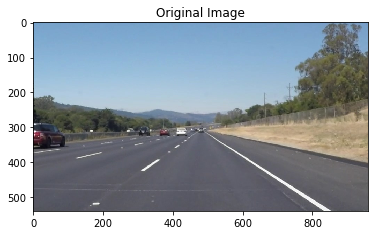

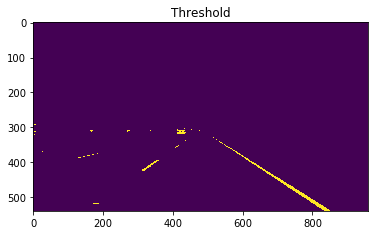

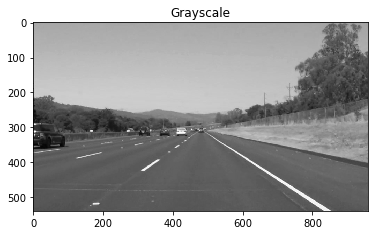

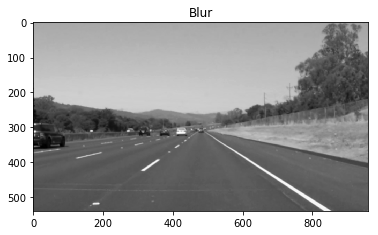

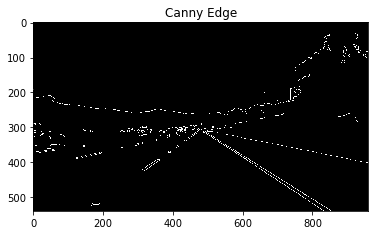

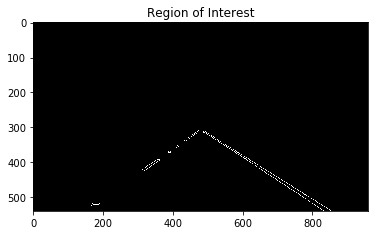

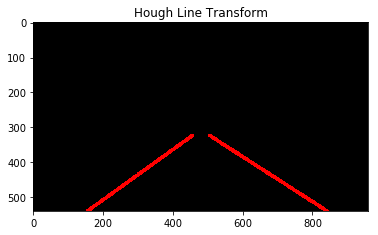

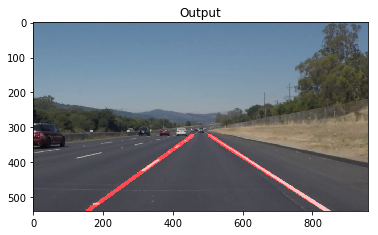

In [3]:
test_image = mpimg.imread('test_images/solidWhiteRight.jpg')

#original image 
plt.subplot(111)
plt.title('Original Image')
plt.imshow(test_image)
plt.show()

#threshold white and yellow
plt.subplot(111)
plt.title('Threshold')
treshold = getthresholdimg(test_image)
plt.imshow(treshold)
plt.show()

#grayscale image
gray_test = grayscale(test_image)
plt.subplot(111)
plt.title('Grayscale')
plt.imshow(gray_test, cmap='gray')
plt.show()

#blur image
blur = gaussian_blur(gray_test, 5)
plt.title('Blur')
plt.imshow(blur, cmap='gray')
plt.show()

#canny edge
edges = canny(blur, 60, 180)
plt.title('Canny Edge')
plt.imshow(edges, cmap='gray')
plt.show()


#region of interest
vertices = np.array([[(0,image.shape[0]),(450, 310), (490, 310), (image.shape[1],image.shape[0])]], dtype=np.int32)
masked_edges = region_of_interest(edges, vertices)
plt.title('Region of Interest')
plt.imshow(masked_edges, cmap='gray')
plt.show()

#hugh transform
rho = 2 
theta = np.pi/180 
threshold = 50     
min_line_len = 30 
max_line_gap = 30   
lines = hough_lines(masked_edges, rho, theta, threshold, min_line_len, max_line_gap)
plt.title('Hough Line Transform')
plt.imshow(lines)
plt.show()

#merge images 
output_image = weighted_img(lines, test_image, α=0.8, β=1., λ=0.)
plt.title('Output')
plt.imshow(output_image)
plt.show()


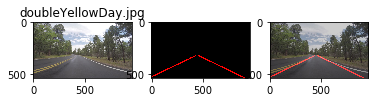

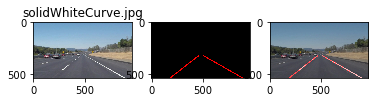

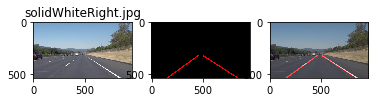

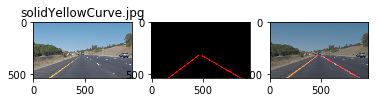

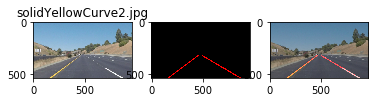

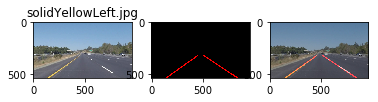

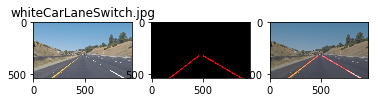

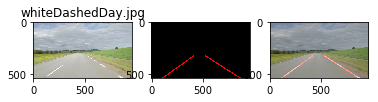

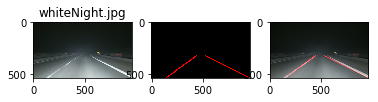

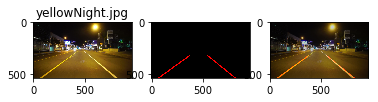

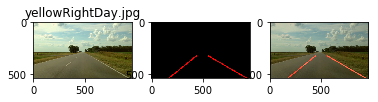

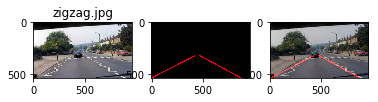

In [4]:
import os
filenames = os.listdir("test_images/")
if '.DS_Store' in filenames: filenames.remove('.DS_Store')

#pipeline variables
kernel_size = 5
low_threshold = 60
high_threshold = 180
vertices = np.array([[(0,image.shape[0]),(450, 310), (490, 310), (image.shape[1],image.shape[0])]], dtype=np.int32)
rho = 2 
theta = np.pi/180 
threshold = 50     
min_line_len = 30 
max_line_gap = 30    

#pipeline for processing images
for file in filenames:
    #load image by reading the file name from filenames
    image = mpimg.imread('test_images/' + file)
    #convert to grayscale
    gray = grayscale(image)
    #blur grayscale image
    blur_gray = gaussian_blur(gray, kernel_size) 
    #canny edge detection on blured image
    edges = canny(blur_gray, low_threshold, high_threshold)
    #mask canny edge image
    masked_edges = region_of_interest(edges, vertices)
    #perform hough line transform on masked image
    lines = hough_lines(masked_edges, rho, theta, threshold, min_line_len, max_line_gap)
    #overlay line image on top of original input image
    final_image = weighted_img(lines, image, α=0.8, β=1., λ=0.)
    #save the output image 
    mpimg.imsave('test_images_output/' + file, final_image)
    #plot a 1x3 figure 
    plt.subplot(131)
    #add a filename title to the first figure
    plt.title(file)
    plt.imshow(image)
    plt.subplot(132)
    plt.imshow(lines)
    plt.subplot(133)
    plt.imshow(final_image)
    plt.show()
    



In [5]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [6]:
#pipeline for processing videos
def lane_detection(image):
    #gaussian blur kernal size
    kernel_size = 5
    #low and high treshold for canny edge detection
    low_threshold = 60
    high_threshold = 180
    #define the shape of our mask
    vertices = np.array([[(0,image.shape[0]),(450, 310), (490, 310), (image.shape[1],image.shape[0])]], dtype=np.int32)
    #variables for hough line transform
    rho = 2 
    theta = np.pi/180 
    threshold = 50     
    min_line_len = 20 
    max_line_gap = 20    
    
    #convert to grayscale
    gray = grayscale(image)
    #blur grayscaled image
    blur_gray = gaussian_blur(gray, kernel_size) 
    #edge detection on blurred image
    edges = canny(blur_gray, low_threshold, high_threshold)
    #mask canny edge image
    masked_edges = region_of_interest(edges, vertices)
    #preform hough line transform on masked image
    lines = hough_lines(masked_edges, rho, theta, threshold, min_line_len, max_line_gap)
    #overlay drawn lines on top of original input image
    final_image = weighted_img(lines, image, α=0.8, β=1., λ=0.)
    #return the processed frame
    return final_image

#pipeline for processing challenge video which changes the image contrast 
def process2(image):
    kernel_size = 5
    low_threshold = 70
    high_threshold = 210
    vertices = np.array([[(270,540),(450, 320), (490, 320), (image.shape[1],image.shape[0])]], dtype=np.int32)
    rho = 2 
    theta = np.pi/180 
    threshold = 50     
    min_line_len = 20 
    max_line_gap = 20
    
    alpha = 1
    beta = -85
    #changes the image contrast to make lines more visable
    brigther = cv2.addWeighted(image, alpha, np.zeros(image.shape, image.dtype), 0, beta)
    
    blur_gray = gaussian_blur(brigther, kernel_size) 
    edges = canny(blur_gray, low_threshold, high_threshold)
    
    masked_edges = region_of_interest(edges, vertices)
    lines = hough_lines(masked_edges, rho, theta, threshold, min_line_len, max_line_gap)
    final_image = weighted_img(lines, image, α=0.8, β=1., λ=0.)

    
    return final_image

#function for testing treshold 
def process3(image):
    kernel_size = 5
    low_threshold = 70
    high_threshold = 210
    vertices = np.array([[(270,540),(450, 320), (490, 320), (image.shape[1],image.shape[0])]], dtype=np.int32)
    #vertices = np.array([[(0,image.shape[0]),(450, 310), (490, 310), (image.shape[1],image.shape[0])]], dtype=np.int32)
    rho = 2 
    theta = np.pi/180 
    threshold = 50     
    min_line_len = 20 
    max_line_gap = 20

    treshold = getthresholdimg(image)
    edges = canny(treshold, low_threshold, high_threshold)
    
    masked_edges = region_of_interest(edges, vertices)
    lines = hough_lines(masked_edges, rho, theta, threshold, min_line_len, max_line_gap)
    final_image = weighted_img(lines, image, α=0.8, β=1., λ=0.)
    
    
    
    return final_image

## Find lanes in videos

In [7]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(lane_detection) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:03<00:00, 56.55it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 3.07 s, sys: 1.23 s, total: 4.3 s
Wall time: 4.52 s


In [8]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [9]:
white_output = 'test_videos_output/solidYellowLeft.mp4'
clip1 = VideoFileClip("test_videos/solidYellowLeft.mp4")
white_clip = clip1.fl_image(lane_detection) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:14<00:00, 46.40it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 10.8 s, sys: 4.19 s, total: 15 s
Wall time: 15.3 s


In [10]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Challenge Video
The pipeline used on the videos above did not work well for the video below, so I added a contrast adjustment to the pipeline to increase accuracy of the lane finding in this video. 

In [11]:
white_output = 'test_videos_output/challenge.mp4'
clip1 = VideoFileClip("test_videos/challenge.mp4")
white_clip = clip1.fl_image(process2) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|██████████| 251/251 [00:13<00:00, 18.79it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 12.5 s, sys: 3.57 s, total: 16 s
Wall time: 15 s


In [12]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [13]:
white_output = 'test_videos_output/tester.mp4'
clip1 = VideoFileClip("test_videos/tester.mp4")
white_clip = clip1.fl_image(lane_detection) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/tester.mp4
[MoviePy] Writing video test_videos_output/tester.mp4


100%|██████████| 58/58 [00:00<00:00, 61.16it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/tester.mp4 

CPU times: user 788 ms, sys: 445 ms, total: 1.23 s
Wall time: 1.47 s


In [14]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

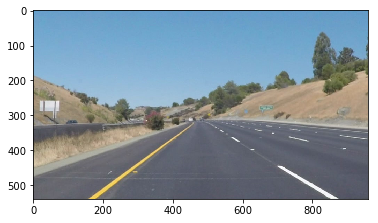

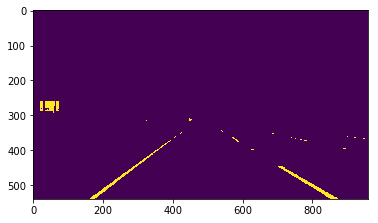

In [15]:
test_image = mpimg.imread('test_images/solidYellowCurve2.jpg')

plt.imshow(test_image)
plt.show()

treshold = getthresholdimg(test_image)
plt.imshow(treshold)
plt.show()




## Zig-zag Lanes
![Input Image](test_images_output/zigzag.jpg)


This solution does an acceptable job in finding straight lines, however, we should keep in mind that in the wild we would require a more robust solution to identify curved, unmarked, and zig-zag lines. 